In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [2]:
# !pip uninstall -y transformers torch deepspeed
# !pip install transformers==4.35.2 torch==2.0.1 deepspeed==0.9.5


In [3]:
# !pip uninstall -y peft
# !pip install peft==0.7.1
# !pip uninstall accelerate
# !pip install accelerate==0.25.0

In [4]:
import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    print(f"\n📁 {dirname}")
    for filename in filenames:
        print(f"  - {filename}")
        


📁 /kaggle/input

📁 /kaggle/input/findsum-roo

📁 /kaggle/input/findsum-roo/FINDSum-ROO

📁 /kaggle/input/findsum-roo/FINDSum-ROO/roo_input_2000
  - train_roo_segment_0_input_2_1000.csv
  - val_roo_segment_0_input_2_1000.csv
  - val_roo_segment_1_input_2_1000.csv
  - test_roo_segment_0_input_2_1000.csv
  - train_roo_segment_1_input_2_1000.csv
  - test_roo_segment_1_input_2_1000.csv


In [5]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.29.0
    Uninstalling huggingface-hub-0.29.0:
      Successfully uninstalled huggingface-hub-0.29.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [6]:
DATA_PATH = "/kaggle/input/findsum-roo/FINDSum-ROO/roo_input_2000"

In [7]:
import pandas as pd
from datasets import Dataset, DatasetDict

train_files = [
    f"{DATA_PATH}/train_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/train_roo_segment_1_input_2_1000.csv"
]

val_files = [
    f"{DATA_PATH}/val_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/val_roo_segment_1_input_2_1000.csv",
    f"{DATA_PATH}/test_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/test_roo_segment_1_input_2_1000.csv"
]

# Load and concat
train_df = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)
val_df = pd.concat([pd.read_csv(f) for f in val_files], ignore_index=True)

# Drop missing
train_df = train_df.dropna(subset=["document", "summary"])
val_df = val_df.dropna(subset=["document", "summary"])

# Convert to Hugging Face Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df[["document", "summary"]]),
    "validation": Dataset.from_pandas(val_df[["document", "summary"]])
})


In [8]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")
MAX_INPUT = 512  # t5-small's max input length
MAX_TARGET = 128

def preprocess(example):
    # T5 expects a task-specific prefix
    inputs = ["summarize: " + doc for doc in example["document"]]
    model_inputs = tokenizer(
        inputs, max_length=MAX_INPUT, truncation=True, padding="max_length"
    )
    
    labels = tokenizer(
        example["summary"], max_length=MAX_TARGET, truncation=True, padding="max_length"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["document", "summary"])


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/33640 [00:00<?, ? examples/s]

Map:   0%|          | 0/8408 [00:00<?, ? examples/s]

In [9]:
import pandas as pd
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

# Load the T5-small model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_finetuned_roo",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer
)

# Start training
trainer.train()


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-9-3a63212d2416>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.780500,2.629637
2,2.713100,2.547150
3,2.719400,2.526177


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=25230, training_loss=2.791340898172845, metrics={'train_runtime': 4687.0149, 'train_samples_per_second': 21.532, 'train_steps_per_second': 5.383, 'total_flos': 1.365869460455424e+16, 'train_loss': 2.791340898172845, 'epoch': 3.0})

In [10]:
# Save model and tokenizer
model.save_pretrained("t5_finetuned_roo")
tokenizer.save_pretrained("t5_finetuned_roo")

# Zip the folder so you can download it
!zip -r t5_finetuned_roo.zip t5_finetuned_roo


  adding: t5_finetuned_roo/ (stored 0%)
  adding: t5_finetuned_roo/added_tokens.json (deflated 83%)
  adding: t5_finetuned_roo/config.json (deflated 63%)
  adding: t5_finetuned_roo/checkpoint-25230/ (stored 0%)
  adding: t5_finetuned_roo/checkpoint-25230/added_tokens.json (deflated 83%)
  adding: t5_finetuned_roo/checkpoint-25230/config.json (deflated 63%)
  adding: t5_finetuned_roo/checkpoint-25230/special_tokens_map.json (deflated 85%)
  adding: t5_finetuned_roo/checkpoint-25230/generation_config.json (deflated 29%)
  adding: t5_finetuned_roo/checkpoint-25230/training_args.bin (deflated 51%)
  adding: t5_finetuned_roo/checkpoint-25230/tokenizer_config.json (deflated 94%)
  adding: t5_finetuned_roo/checkpoint-25230/rng_state.pth (deflated 25%)
  adding: t5_finetuned_roo/checkpoint-25230/optimizer.pt (deflated 7%)
  adding: t5_finetuned_roo/checkpoint-25230/trainer_state.json (deflated 81%)
  adding: t5_finetuned_roo/checkpoint-25230/scheduler.pt (deflated 56%)
  adding: t5_finetuned_r

🧠 Final Perplexity: 12.51


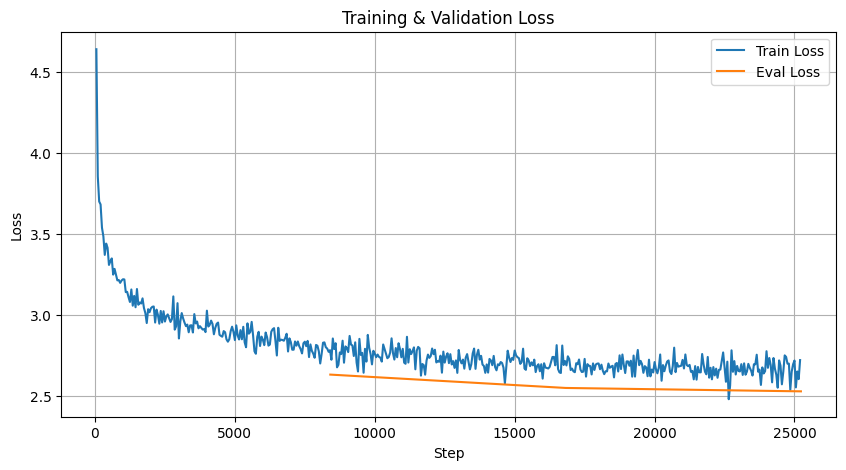

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training logs
logs = trainer.state.log_history

# Separate losses and steps
train_loss = [entry["loss"] for entry in logs if "loss" in entry and "eval_loss" not in entry]
eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
train_steps = [entry["step"] for entry in logs if "loss" in entry and "eval_loss" not in entry]
eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]

# Calculate final perplexity
perplexity = np.exp(eval_loss[-1])
print(f"🧠 Final Perplexity: {perplexity:.2f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
!pip install rouge_score



  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5ee3cf7379cfb6d17b91702ad594ae0b7dbf9c501e91d69997d5f2c0998d6280
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [13]:
import evaluate

rouge = evaluate.load("rouge")

# We'll run on 100 samples from the validation set
sample_val = dataset["validation"].select(range(100))

preds, refs = [], []

for example in sample_val:
    input_ids = tokenizer(
        example["document"],
        return_tensors="pt",
        max_length=1024,
        truncation=True,
        padding="max_length"
    ).input_ids.to(model.device)

    output_ids = model.generate(input_ids, max_length=256)
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    preds.append(pred)
    refs.append(example["summary"])

# Compute ROUGE
rouge_scores = rouge.compute(predictions=preds, references=refs)
for key in rouge_scores:
    print(f"{key}: {rouge_scores[key]:.4f}")


rouge1: 0.2014
rouge2: 0.0826
rougeL: 0.1469
rougeLsum: 0.1465


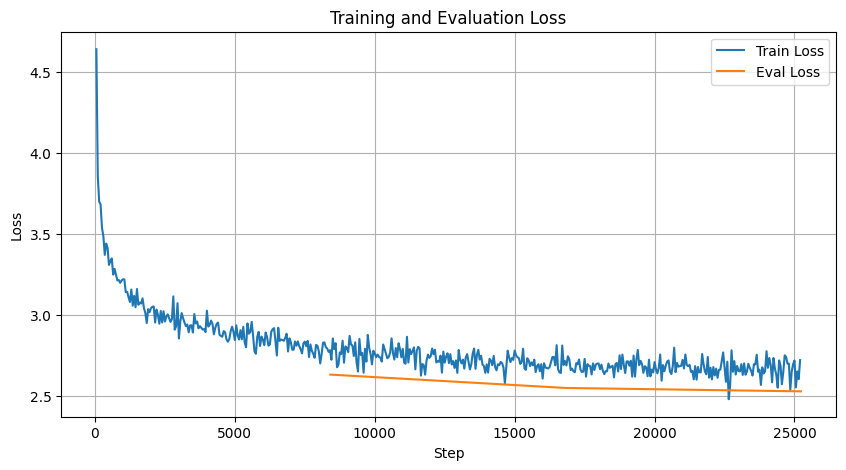

In [14]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x and "eval_loss" not in x]
eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
steps = [x["step"] for x in logs if "loss" in x and "eval_loss" not in x]
eval_steps = [x["step"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid()
plt.show()


In [15]:
!zip -r t5_finetuned_roo.zip t5_finetuned_roo


updating: t5_finetuned_roo/ (stored 0%)
updating: t5_finetuned_roo/added_tokens.json (deflated 83%)
updating: t5_finetuned_roo/config.json (deflated 63%)
updating: t5_finetuned_roo/checkpoint-25230/ (stored 0%)
updating: t5_finetuned_roo/checkpoint-25230/added_tokens.json (deflated 83%)
updating: t5_finetuned_roo/checkpoint-25230/config.json (deflated 63%)
updating: t5_finetuned_roo/checkpoint-25230/special_tokens_map.json (deflated 85%)
updating: t5_finetuned_roo/checkpoint-25230/generation_config.json (deflated 29%)
updating: t5_finetuned_roo/checkpoint-25230/training_args.bin (deflated 51%)
updating: t5_finetuned_roo/checkpoint-25230/tokenizer_config.json (deflated 94%)
updating: t5_finetuned_roo/checkpoint-25230/rng_state.pth (deflated 25%)
updating: t5_finetuned_roo/checkpoint-25230/optimizer.pt (deflated 7%)
updating: t5_finetuned_roo/checkpoint-25230/trainer_state.json (deflated 81%)
updating: t5_finetuned_roo/checkpoint-25230/scheduler.pt (deflated 56%)
updating: t5_finetuned_r

In [16]:
model.save_pretrained("bart_roo_finetuned")
tokenizer.save_pretrained("bart_roo_finetuned")

# Optionally zip it for download
!zip -r t5_finetuned_roo.zip t5_finetuned_roo


updating: t5_finetuned_roo/ (stored 0%)
updating: t5_finetuned_roo/added_tokens.json (deflated 83%)
updating: t5_finetuned_roo/config.json (deflated 63%)
updating: t5_finetuned_roo/checkpoint-25230/ (stored 0%)
updating: t5_finetuned_roo/checkpoint-25230/added_tokens.json (deflated 83%)
updating: t5_finetuned_roo/checkpoint-25230/config.json (deflated 63%)
updating: t5_finetuned_roo/checkpoint-25230/special_tokens_map.json (deflated 85%)
updating: t5_finetuned_roo/checkpoint-25230/generation_config.json (deflated 29%)
updating: t5_finetuned_roo/checkpoint-25230/training_args.bin (deflated 51%)
updating: t5_finetuned_roo/checkpoint-25230/tokenizer_config.json (deflated 94%)
updating: t5_finetuned_roo/checkpoint-25230/rng_state.pth (deflated 25%)
updating: t5_finetuned_roo/checkpoint-25230/optimizer.pt (deflated 7%)
updating: t5_finetuned_roo/checkpoint-25230/trainer_state.json (deflated 81%)
updating: t5_finetuned_roo/checkpoint-25230/scheduler.pt (deflated 56%)
updating: t5_finetuned_r